In [1]:
from tools import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from scipy.stats import multivariate_normal
from scipy.misc import derivative
from scipy.linalg import fractional_matrix_power
from scipy.stats import wishart
import sys
import time

In [5]:
def logistic_inverse(x):
    return(-np.log(1/x-1))
#     return scipy.stats.logistic.ppf(x)

def logistic_diff(x):
    return(abs(1/x+1/(1-x)))
#     return abs(derivative(logistic_inverse,x,dx=1e-6))

def t_inverse(x):
    return scipy.stats.t.ppf(x,df=2)

def t_diff(x):
    return abs(derivative(t_inverse,x,dx=1e-6))

def exp_inverse(x):
    return(-np.log(x))

def exp_diff(x):
    return(abs(1/x))

def logtargetpdf(x, target, kernel):
    lnp = 0.0
    if (target == 'Exp'):
        if 'Trans' in kernel:
            lnp = 0 if 0<=x<=1 else -500
        else:
            lnp = -x if (x>=0) else -500
    elif (target == 'Folded_Gaussian'):
        if 'Trans' in kernel:
            x_inv = exp_inverse(x)
            lnp = -x_inv*x_inv/2 + np.log(exp_diff(x)) if 0<=x<=1 else -500
        else:
            lnp = -x*x/2 if (x>=0) else -500
    elif (target == 'N01_T2'):
        if 'Trans' in kernel:
            x_inv = t_inverse(x)
            lnp = -x_inv*x_inv/2 + np.log(t_diff(x)) if 0<=x<=1 else -500
        else:
            lnp = -x*x/2
    elif (target == 'N01_Logistic'):
        if 'Trans' in kernel:
            x_inv = logistic_inverse(x)
            lnp = -x_inv*x_inv/2 + np.log(logistic_diff(x)) if 0<=x<=1 else -500
        else:
            lnp = -x*x/2
    return (lnp)

In [15]:
#MCMC sampling implementation
# np.random.seed(121)
begin_total = time.time()
nround = int(10e5)
burnin = int(10e4)
size = len(range(-burnin,nround))
sigmaset = [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1, 1.1, 1.3, 1.5, 1.7,
                    1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.8,
                    3.0, 3.2, 3.5, 4, 4.5, 5, 6, 7, 8]
kernelset = ['Uniform','TransUniform','TransBactrian','TransStrawHat']
targetset = ['Exp','Folded_Gaussian','N01_Logistic']

sample_Normal = np.random.normal(size = size)
sample_Uniform = np.random.uniform(low=-np.sqrt(3), high=np.sqrt(3), size=size)
sample_bactrian = random_bactrian(size = size)
sample_strawhat = random_strawhat(size=size)
target_result = {}

for target in targetset:
    eff_kernel = {}; Pjump_kernel = {}; Exx2_kernel = {}; Rho_kernel={}; Sample_kernel={}
    for kernel in kernelset:
        Eff = []; Pjump = []; Exx2=[]; Rho=[]; Sample=[]
        for sigma in sigmaset:
            begin_loop = time.time()
            exx2 = 0; accept = 0; 
            x = abs(np.random.random() - 0.5)
            y = np.zeros(nround)
            for j in range(-burnin,nround):
                if (j==0):
                    accept = 0;
                if 'Gaussian' in kernel:
                    xnew = x + sample_Normal[j+burnin] * sigma
                elif 'Uniform' in kernel:
                    xnew = x + sample_Uniform[j+burnin] *sigma
                elif 'Bactrian' in kernel:
                    xnew = x + sample_bactrian[j+burnin] *sigma
                elif 'StrawHat' in kernel:
                    xnew = x + sample_strawhat[j+burnin] *sigma

                
                if (('Trans' in kernel) & (not (0 <= xnew <= 1))):
                    xnew = reflect(xnew, xL=0, xU=1)
                if (((target=='Exp') | (target=='Folded_Gaussian')) & ('Trans' not in kernel)) & (xnew<0):
                    xnew = -xnew

                pi_dif = logtargetpdf(xnew,target,kernel) - logtargetpdf(x,target,kernel)
                if ((pi_dif>0) | (np.exp(pi_dif)>np.random.random())):
                    x = xnew
                    accept += 1
                if (j>=0):
                    if (((target=='Exp')|(target=='Folded_Gaussian')) & ('Trans' in kernel)):
                        y[j] = exp_inverse(x)
                    elif ((target=='N01_Logistic') & ('Trans' in kernel)):
                        y[j] = logistic_inverse(x)
                    else:
                        y[j] = x
            eff = (Eff_IntegratedCorrelationTime(y))
            rho = [rho_k(y,i) for i in range(1,11)]
            exx2 = sum(np.square(y[1:] - y[:-1]))
            Eff.append(eff)
            Pjump.append(accept/nround)
            Exx2.append(exx2/nround)
            Rho.append(rho)
            Sample.append(y.copy())
            print ('Target:',target,'|Kernel:',kernel,'|sigma:',sigma,'|eff:',round(eff,4), '|Pjump:', round(accept/nround,4), '|Exx2:', round(exx2/nround,4),
                   '|rho1:', round(rho[0],4), '|rho2:', round(rho[1],4) ,'|Time:',round((time.time()-begin_loop),2),sep='')
        eff_kernel[kernel] = Eff
        Pjump_kernel[kernel] = Pjump
        Exx2_kernel[kernel] = Exx2
        Rho_kernel[kernel] = Rho
        Sample_kernel[kernel] = Sample
    target_result[target] = [eff_kernel,Pjump_kernel,Exx2_kernel,Rho_kernel,Sample_kernel]
print('总共用时: %f'% (time.time()-begin_total))

Target:N01_Logistic|Kernel:TransStrawHat|sigma:0.7|eff:0.9918|Pjump:0.6652|Exx2:2.0359|rho1:-0.0178|rho2:0.0177|Time:19.57
Target:N01_Logistic|Kernel:TransStrawHat|sigma:0.8|eff:1.4899|Pjump:0.7435|Exx2:2.3875|rho1:-0.1967|rho2:0.0416|Time:19.6
Target:N01_Logistic|Kernel:TransStrawHat|sigma:0.9|eff:1.5592|Pjump:0.7636|Exx2:2.4276|rho1:-0.2155|rho2:0.047|Time:19.51
Target:N01_Logistic|Kernel:TransStrawHat|sigma:1|eff:1.4307|Pjump:0.7453|Exx2:2.3688|rho1:-0.1906|rho2:0.0431|Time:19.86
Target:N01_Logistic|Kernel:TransStrawHat|sigma:1.1|eff:1.329|Pjump:0.7112|Exx2:2.3119|rho1:-0.1531|rho2:0.0332|Time:19.83
总共用时: 98.594364


### The plot below is the probability density of  target after transformed:

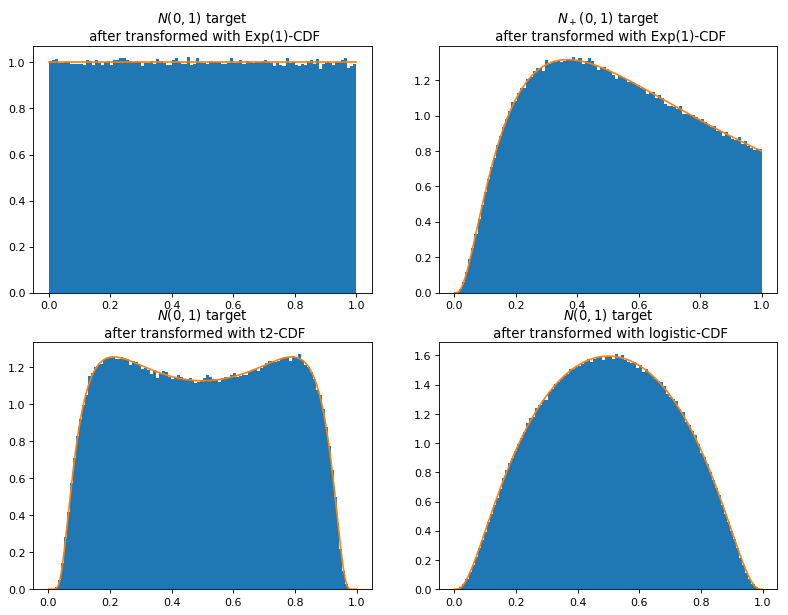

In [52]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################

from matplotlib.pyplot import figure
figure(num=None, figsize=(12,9), dpi=80, facecolor='w', edgecolor='k')

ori = np.random.exponential(size=1000000,scale=1.0)
trans = np.exp(-ori)
xindex = np.arange(0.001,0.999,0.001)
yindex = np.ones(len(xindex))
plt.subplot(221)
plt.hist(trans, bins=100, density=True)
plt.plot(xindex,yindex)
plt.gca().set_title('$N(0,1)$ target \n after transformed with Exp(1)-CDF')

ori = abs(np.random.normal(size=1000000))
trans = np.exp(-ori)
xindex = np.arange(0.001,0.999,0.001)
inverse = np.array([exp_inverse(i) for i in xindex])
diff_term = np.array([exp_diff(i) for i in xindex])
yindex = 2*scipy.stats.norm.pdf(inverse) * diff_term
plt.subplot(222)
plt.hist(trans, bins=100, density=True)
plt.plot(xindex,yindex)
plt.gca().set_title('$N_+(0,1)$ target \n after transformed with Exp(1)-CDF')


ori = np.random.normal(size=1000000)
trans = scipy.stats.t.cdf(x=ori,df=2)
xindex = np.arange(0.001,0.999,0.001)
inverse = np.array([t_inverse(i) for i in xindex])
diff_term = np.array([t_diff(i) for i in xindex])
yindex = scipy.stats.norm.pdf(inverse) * diff_term
plt.subplot(223)
plt.hist(trans, bins=100, density=True)
plt.plot(xindex,yindex)
plt.gca().set_title('$N(0,1)$ target \n after transformed with t2-CDF')

ori = np.random.normal(size=1000000)
trans = scipy.stats.logistic.cdf(x=ori)
xindex = np.arange(0.001,0.999,0.001)
inverse = np.array([logistic_inverse(i) for i in xindex])
diff_term = np.array([logistic_diff(i) for i in xindex])
yindex = scipy.stats.norm.pdf(inverse) * diff_term
plt.subplot(224)
plt.hist(trans, bins=100, density=True)
plt.plot(xindex,yindex)
plt.gca().set_title('$N(0,1)$ target \n after transformed with logistic-CDF')

plt.show()